In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.filters import frangi

#ocena skuteczności
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import gmean
import pandas as pd


from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

In [2]:
size = (512, 512)
input_shape = [512, 512, 3]

In [3]:
def read_and_process_image(image_path):
    # Wczytaj obraz kolorowy (BGR)
    img = cv2.imread(f'all/images/{image_path}.jpg')
    img = cv2.resize(img, size)

    # Zostaw tylko zielony kanał
    green_channel = img[:, :, 1]

    # Ograniczenie wartości pikseli
    green_channel = np.clip(green_channel, 10, 245)

    # Zastosowanie CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(green_channel)

    return image


def read_mask(image_name):
    # Wczytanie maski eksperckiej
    mask = cv2.imread(f'all/manual1/{image_name}.tif', cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size)
    mask_norm = (mask > 127).astype(int)

    return mask_norm

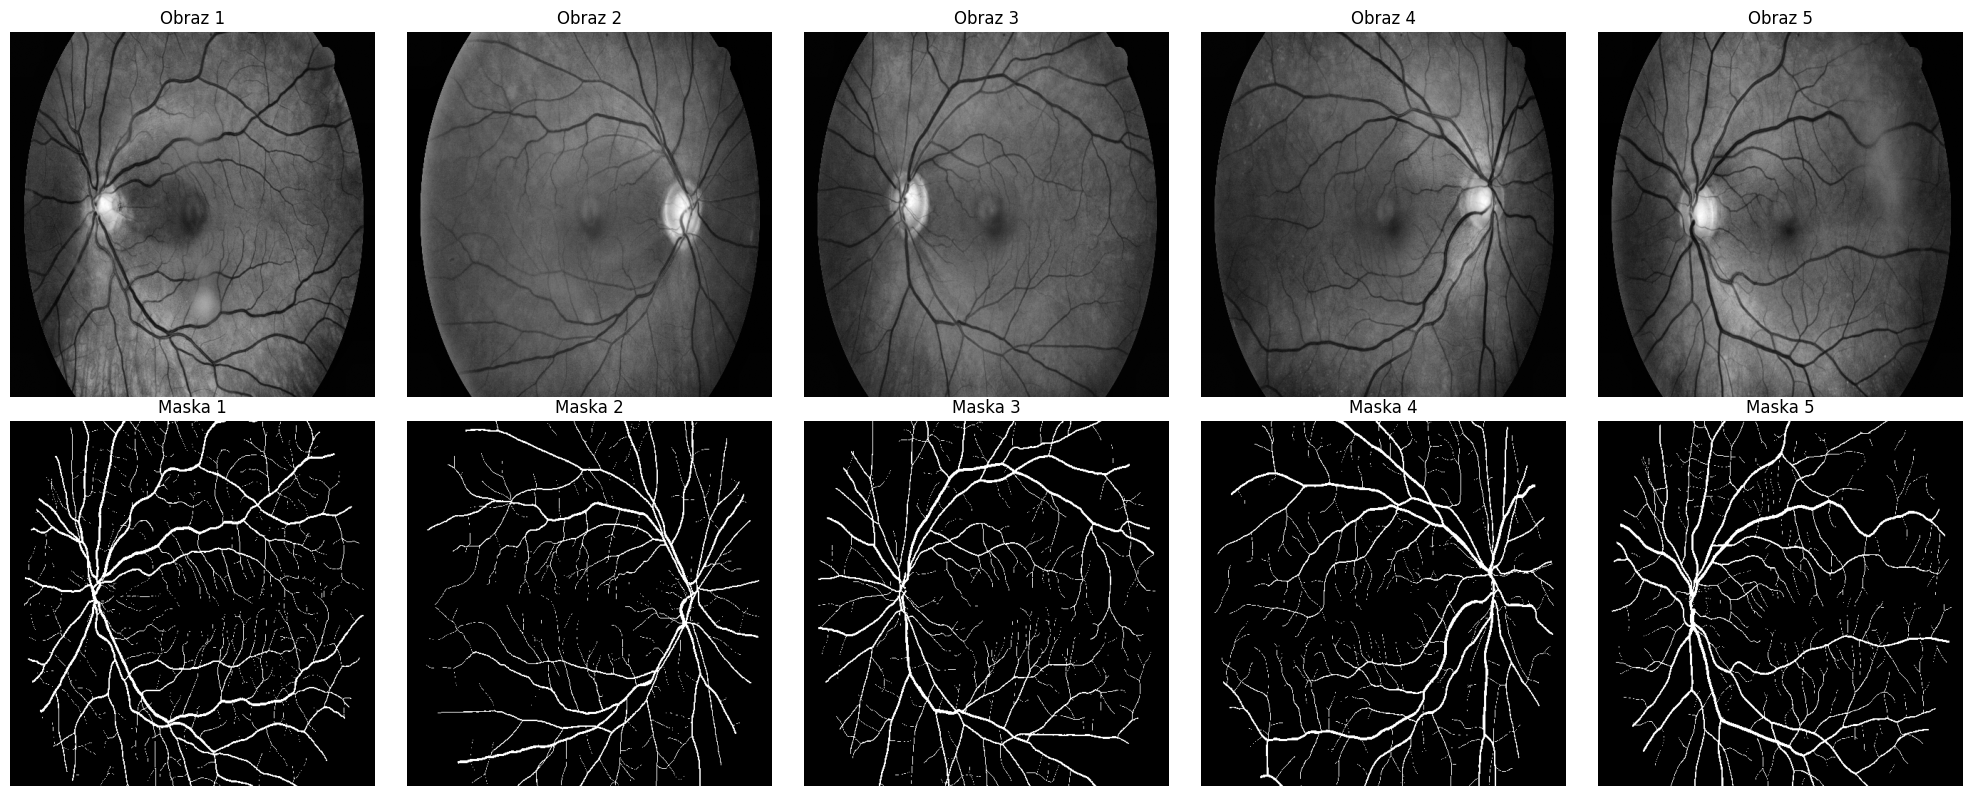

In [4]:
# Przykład użycia dla wielu obrazów
image_names = ['02_g', '03_g', '04_g', '05_g', '06_g']

processed_images = []
masks = []
for name in image_names:
    processed_img = read_and_process_image(name)
    mask = read_mask(name)
    processed_images.append(processed_img)
    masks.append(mask)
    
plt.figure(figsize=(20, 8))

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(processed_images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Obraz {i+1}')

for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Maska {i+1}')

plt.tight_layout()
plt.show()

In [5]:
def create_dataset_matrix(image, mask, patch_size=21):

    image_height, image_width = image.shape
    num_patches_x = image_width // patch_size
    num_patches_y = image_height // patch_size
    
    # Inicjalizacja macierzy (liczba patchy x (rozmiar patcha + etykieta))
    dataset_matrix = np.zeros((num_patches_x * num_patches_y, patch_size**2 + 1))
    
    for i in range(0, image_width, patch_size):
        for j in range(0, image_height, patch_size):
            
            # Pomijaj fragmenty wychodzące poza obraz
            if (i + patch_size > image_width) or (j + patch_size > image_height):
                continue
                
            # Wycinanie fragmentu
            patch = image[j:j+patch_size, i:i+patch_size]
            
            # Oblicz indeks wiersza w macierzy
            row_idx = (i // patch_size) * num_patches_y + (j // patch_size)
            
            # Spłaszcz fragment do 1D i dodaj do macierzy
            dataset_matrix[row_idx, :-1] = patch.flatten()
            
            # Pobierz etykietę ze środka fragmentu
            center_y = j + patch_size // 2
            center_x = i + patch_size // 2
            dataset_matrix[row_idx, -1] = mask[center_y, center_x]
    
    return dataset_matrix


In [6]:
#stworzenie macierzy danych
dataset = create_dataset_matrix(processed_images[0], masks[0])




#budowa klasyfikatora

X = dataset[:, :-1]  # wszystkie cechy
y = dataset[:, -1]   # etykieta (ostatnia kolumna)

#Podział danych na dane treningowe i testowe - (podział warstwowy - stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

# Undersampling tylko na zbiorze uczącym
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)




# Build pipeline
# Definiowanie modelu

rfc = RandomForestClassifier()

pipeline = Pipeline([
    ('rfc', rfc)
])

# Definiowanie siatki parametrów do przetestowania
param_grid = {
    'rfc__n_estimators': [10, 100],
    'rfc__max_depth': [None, 20],
    'rfc__min_samples_leaf': [1, 2],
    'rfc__min_samples_split': [2, 5]
}

# Definiowanie obiektu GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)

# Dopasowanie modelu do danych
grid_search.fit(X_train_balanced, y_train_balanced)


GridSearchCV(estimator=Pipeline(steps=[('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [None, 20],
                         'rfc__min_samples_leaf': [1, 2],
                         'rfc__min_samples_split': [2, 5],
                         'rfc__n_estimators': [10, 100]})

In [7]:
# Po wytrenowaniu grid_search wykonaj predykcję na zbiorze testowym
y_pred = grid_search.best_estimator_.predict(X_test)
y_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # prawdopodobieństwa dla klasy 1

# Oblicz metryki jakości
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, RocCurveDisplay)

print("\nNajlepsze parametry:", grid_search.best_params_)
print("=====================================\n")

# Podstawowe metryki
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

print('Training accuracy:', grid_search.score(X_train_balanced, y_train_balanced))
print('Test accuracy:', grid_search.score(X_test, y_test))


Najlepsze parametry: {'rfc__max_depth': 20, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100}

Accuracy: 0.885
Precision: 0.188
Recall: 0.250
F1-score: 0.214
ROC AUC: 0.772
Training accuracy: 1.0
Test accuracy: 0.8848167539267016


Liczba patchy: 242064
Zużycie RAM: 0.09941889345645905 GB
Liczba patchy: 242064
Zużycie RAM: 0.09941889345645905 GB
Liczba patchy: 242064
Zużycie RAM: 0.09941889345645905 GB
Liczba patchy: 242064
Zużycie RAM: 0.09941889345645905 GB
Liczba patchy: 242064
Zużycie RAM: 0.09941889345645905 GB


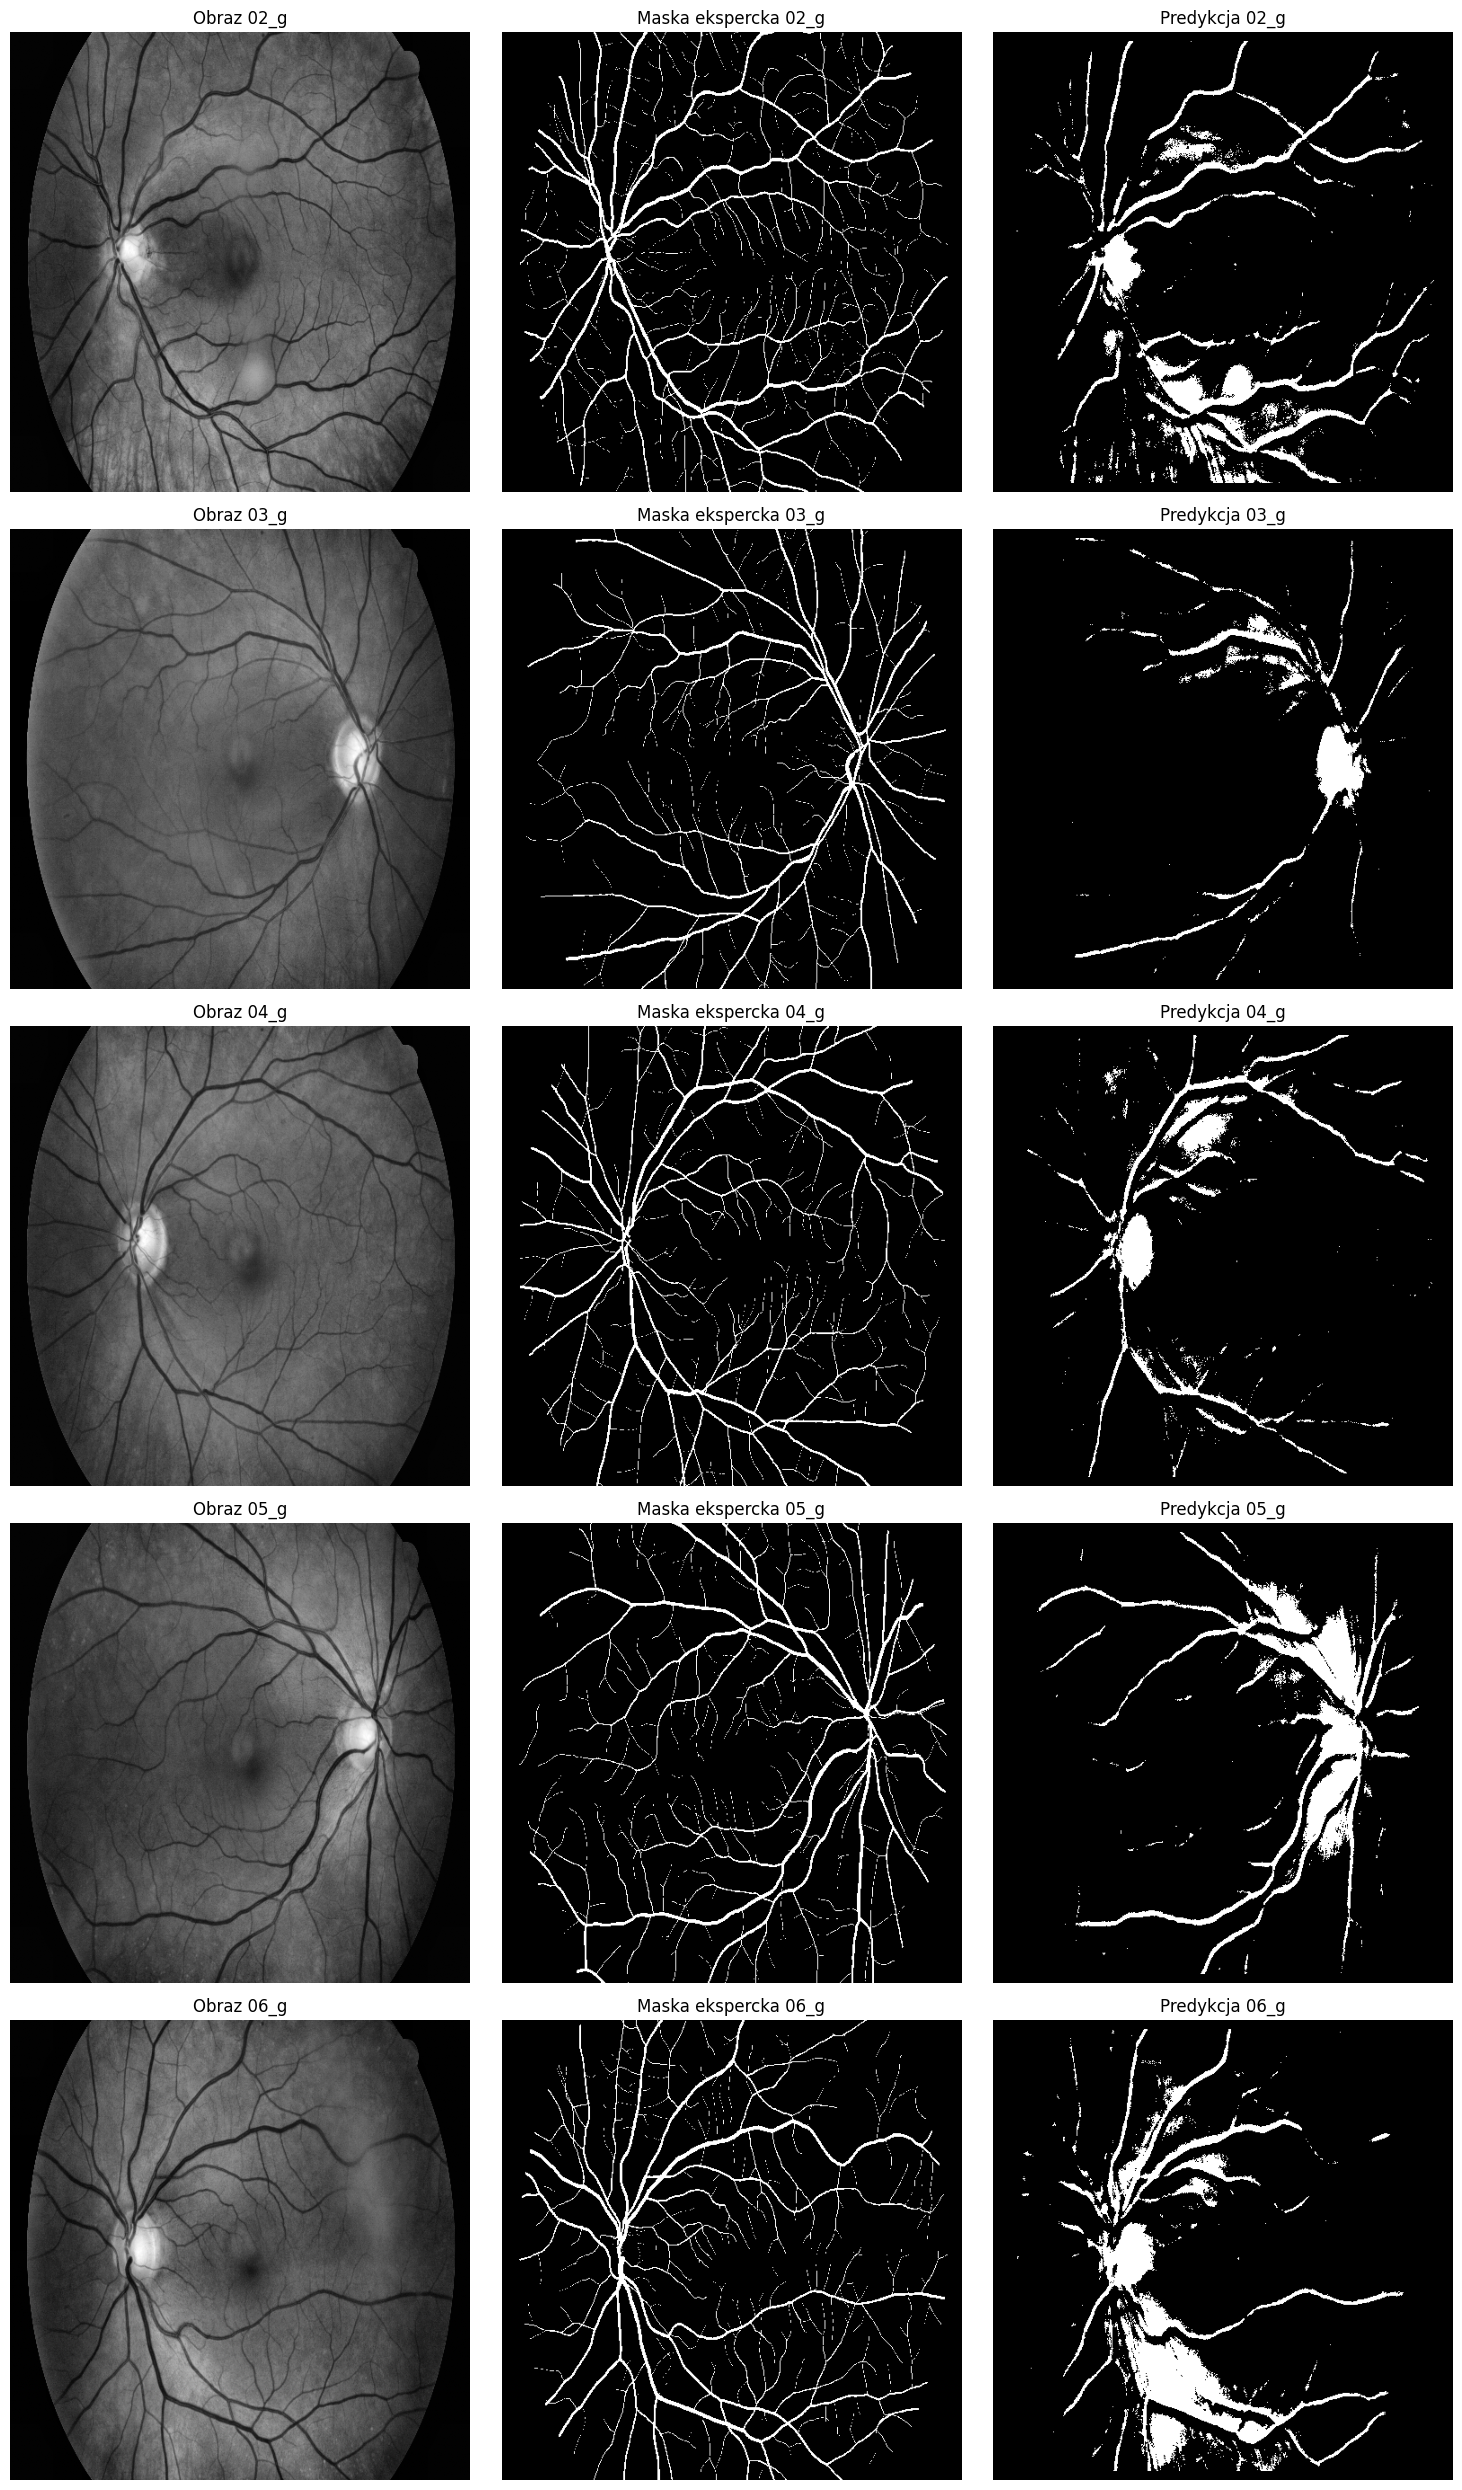

In [8]:
patch_size=21

plt.figure(figsize=(15, 25))

for idx, (img, mask) in enumerate(zip(processed_images, masks)):


    image_height, image_width = img.shape
    offset = patch_size // 2

    # Inicjalizacja macierzy do predykcji (wymiar mniejszy o 2*offset, bo patchy nie można wycinać na brzegach)
    predicted_mask = np.zeros((image_height, image_width), dtype=np.uint8)

    # Tworzymy zbiór patchy i przewidujemy je
    patches = []
    positions = []

    step = 1

    for y in range(offset, image_height - offset, step):
        for x in range(offset, image_width - offset, step):
            patch = img[y - offset:y + offset + 1, x - offset:x + offset + 1]
            patches.append(patch.flatten())
            positions.append((y, x))

    patches = np.array(patches)  # kształt (liczba_patchy, patch_size*patch_size)

    print("Liczba patchy:", len(patches))
    print("Zużycie RAM:", patches.nbytes / 1024**3, "GB")


    # Predykcja na patchach
    y_pred = grid_search.predict(patches)  # powinno zwrócić etykietę dla każdego patcha

    # Wstawiamy wyniki do macierzy predicted_mask w pozycji centralnego piksela patcha
    for (y, x), pred in zip(positions, y_pred):
        predicted_mask[y, x] = pred

    
    # Wizualizacja w układzie 5 wierszy x 3 kolumny
    plt.subplot(5, 3, 3*idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Obraz {image_names[idx]}')
    plt.axis('off')
    
    plt.subplot(5, 3, 3*idx + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Maska ekspercka {image_names[idx]}')
    plt.axis('off')
    
    plt.subplot(5, 3, 3*idx + 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f'Predykcja {image_names[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()